# Fraud Detection


### Design Doc

__Scope__

The idea here is to follow this design document to build our initial baseline model and reuse as much code as possible and do so relatively quickly.

I tested this approach with this data: https://www.kaggle.com/mlg-ulb/creditcardfraud


__Goal__

Predict ```Class``` label, which represents fraudulent activity.

The ```Class``` label is relatively rare, which means our dataset is imbalanced. 

    
__Baseline Feature Engineering__

1. Remove features that entirely null.
2. Time based features: hour, day, etc.. (if any).
3. Categorical features should be one-hot encoded (if any).
4. Dollar features should be logged (if any).
5. Non monetary continuous features scaled.
6. Perhaps some row level statistics.
6. Upsampling.

Things to be wary of:

    - leakage
    - features that are in our test set (or production) that may not be in our training data
    - When oversampling, do not oversample test set.

__Baseline Model and Error Metric__

1. Tree based model, XGboost. The decision to use XGBoost over other tree implementations comes down to speed, flexibility, and performance. XGBoost allows for custom optimization functions and parallelized for speed. 

2. I think we will be looking at the precision and recall on our two classes as well as AUC. XGBoost allows for the following evaluation metrics: log loss, auc, and auc pr (precision and recall).

    - Binary classification problem
    - Imbalanced data
    - True positive and/or False positive rate may be important to judge performance

__Project Structure__

```
\utils
- utils.py
- models.py
- pipeline.py
```

__Steps__

1. Clean data.
2. Pass clean data through Pipeline.
3. Train and evaluate baseline model.

Repeat process but with random oversampling.

__First Baseline__


The initial model seems to perform relatively well in terms of precision and precision for the fraud class:

```
ROC score: 0.9521513784678161

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28429
           1       0.90      0.52      0.66        52

    accuracy                           1.00     28481
   macro avg       0.95      0.76      0.83     28481
weighted avg       1.00      1.00      1.00     28481

```

To help improve the recall of our model we will use random oversampling with the Python package ```imbalanced-learn,``` I referred to this [documentation](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#random-over-sampler).


__Upsampling__

By upsampling our data our original baseline model performs better:

```
ROC score: 0.9791731493031223

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28429
           1       0.76      0.85      0.80        52

    accuracy                           1.00     28481
   macro avg       0.88      0.92      0.90     28481
weighted avg       1.00      1.00      1.00     28481

```

We increased recall on the fraud class label from 0.52 to 0.85. However Precision took a hit. However if we adjust the threshold of prediction we can concentrate on the cases we are most confident in. For example adjusting the prediction threshold to 0.8 we get 90% of cases. On the other hand we only capture a small percentage of overall fraud cases. 


If we adjust the prediction threshold we can focus on those case we have the most confidence in:

```
[(0.1, 0.0018258426966292136), 
 (0.2, 0.0344311377245509),
 (0.3, 0.20087336244541484),
 (0.4, 0.5056179775280899),
 (0.5, 0.7586206896551724),
 (0.6, 0.8148148148148148),
 (0.7, 0.86),
 (0.8, 0.8913043478260869),
 (0.9, 1)]

```

__Additional Issues__

While we can adjust our prediction threshold to caputure the majority of cases for small percentage of fraud cases, the question I ask myself is: Are these the most risky cases, i.e. most costly?


__Things that I did not do, but if I had time I would have__

1. Synthetic Minority Oversampling Technique (SMOTE), this method seems to take a long time to fit; therefore I decided not to pursue it.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

```python
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
```

2. Hyperparameter optimization. I think the important issue was resampling the data. I know I could have spent some significant time on hyperparameter optimization.

3. Cross-validation. I think there would have been additional complexity combining cross-validation with random oversampling and by extension time spent on doing just that; therefore I kept things simple. However I think cross-validation would improve the performance here since we are using a tree based approach, which has issues with variance.

In [35]:
%load_ext autoreload
%autoreload 2

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from utils.models import Processing, Models, Metrics

sns.set(style="dark")

%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df.shape

(284807, 31)

In [4]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [5]:
df['Class'].describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

In [6]:
Counter(df['Class'])

Counter({0: 284315, 1: 492})

Text(0.5, 0, 'Amount')

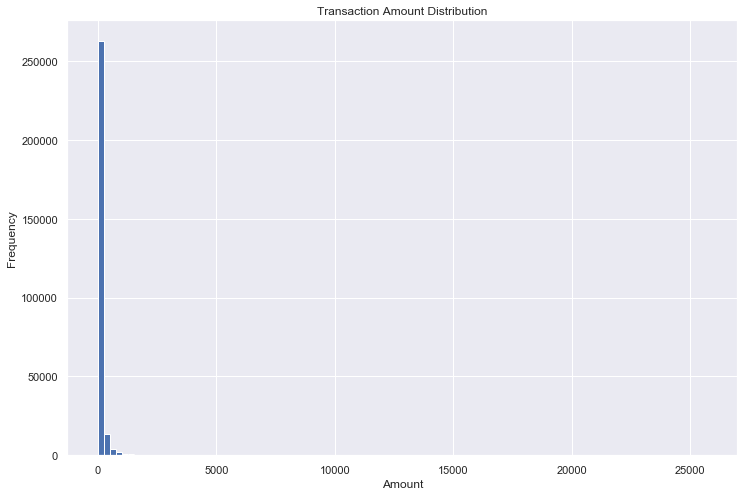

In [6]:
df['Amount'].hist(bins = 100, figsize=(12, 8))
plt.title('Transaction Amount Distribution')
plt.ylabel('Frequency')
plt.xlabel('Amount')

In [7]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
# clean train
train = Processing.clean(df)

In [9]:
# create feature and target 
X = train.drop(['Class'], axis = 1)
y = train['Class']

In [10]:
pipe = Processing.features(X)

In [11]:
pipe.fit(X)
X = pipe.transform(X)

In [12]:
Models.baseline(X, y)

/Users/maitsukiyama/miniconda3/envs/test/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.877393	valid-auc:0.924628
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.888379	valid-auc:0.924586
[2]	train-auc:0.900588	valid-auc:0.92446
[3]	train-auc:0.900526	valid-auc:0.924418
[4]	train-auc:0.918312	valid-auc:0.936755
[5]	train-auc:0.918083	valid-auc:0.936622
[6]	train-auc:0.922425	valid-auc:0.942932
[7]	train-auc:0.951965	valid-auc:0.945401
[8]	train-auc:0.951844	valid-auc:0.945301
[9]	train-auc:0.95181	valid-auc:0.945292
[10]	train-auc:0.951271	valid-auc:0.944774
[11]	train-auc:0.95129	valid-auc:0.944797
[12]	train-auc:0.952377	valid-auc:0.94455
[13]	train-auc:0.952432	valid-auc:0.951237
[14]	train-auc:0.952465	valid-auc:0.951254
[15]	train-auc:0.952338	valid-auc:0.95116
[16]	train-auc:0.953736	valid-auc:0.951134
[17]	train-auc:0.953752	valid-auc:0.951078
[18]	train-auc:0.953564	valid-auc:0.950983
[19]	train-auc:0.953592	valid-auc:0.950945
[20]	train-a

In [15]:
Models.resample_baseline(X, y)

/Users/maitsukiyama/miniconda3/envs/test/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.993238	valid-auc:0.945229
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.994024	valid-auc:0.947909
[2]	train-auc:0.998402	valid-auc:0.962996
[3]	train-auc:0.99925	valid-auc:0.977756
[4]	train-auc:0.999472	valid-auc:0.987629
[5]	train-auc:0.999727	valid-auc:0.986892
[6]	train-auc:0.999763	valid-auc:0.986536
[7]	train-auc:0.99978	valid-auc:0.984592
[8]	train-auc:0.99979	valid-auc:0.98276
[9]	train-auc:0.999822	valid-auc:0.983861
[10]	train-auc:0.999835	valid-auc:0.985182
[11]	train-auc:0.999844	valid-auc:0.983808
[12]	train-auc:0.999847	valid-auc:0.984058
[13]	train-auc:0.999848	valid-auc:0.984244
[14]	train-auc:0.999849	valid-auc:0.982994
Stopping. Best iteration:
[4]	train-auc:0.999472	valid-auc:0.987629

ROC score: 0.9791731493031223
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28429
           1      